### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import nltk
import nltk.translate.bleu_score as bleu

import tqdm
from tqdm import tqdm 

import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations

import warnings
warnings.filterwarnings("ignore") 

import time

In [2]:
from google.colab import drive 
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir("/content/drive/MyDrive/Medical Report Generation Using Deeplearning/Medical Report Generation Using Deeplearning") 

Here we extract the image features using CheXNet model itself.
Now,instead of giving this features directly to the decoder model we perform some attention mechanism on the image features. Now, to the decoder, we give the context vector we obtained after attention which contains the relative importance of image regions. So based on this context vector the decoder generate the most apppropriate word.

## CheXnet Model

In [4]:

#The trained weight of chexnet nodel (DenseNet121) is from https://github.com/brucechou1983/CheXNet-Keras

from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))

base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape)
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
chexnet_model.load_weights("chexnet_weights.h5")

chexnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

loaded the pre-trained chexnet model and removed the last layer, and we took the output from the second last layer  as the image features

In [5]:
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")    

### Read the data containing image paths and reports

In [9]:
# split the data set into train and test data
# train=pd.read_csv("train")
# test=pd.read_csv("test") 

In [6]:
data=pd.read_csv("data.csv")
train,test=train_test_split(data,test_size=0.2,random_state=1,shuffle=True)
print(train.shape) 
print(test.shape)

(3052, 5)
(764, 5)


In [56]:
length=[]
for rep in train["report"]:
  length.append(len(rep.split()))
  
print("max length is ",np.max(length))
print("90th percentile is ",np.percentile(length,90))
print("99th percentile is ",np.percentile(length,99))



max length is  135
90th percentile is  41.0
99th percentile is  66.0


In [12]:
# test.to_csv("test")
# train.to_csv("train")

In [8]:
'''
Predict the 7,7,1024 dimensional vector for two images from the final chexnet model and concatenate these features.
to get 7,14,1024 dimensional vector. Now to perform the attention mechansm we convert this into (7x14),1024 dimensional tensor.'''
def image_feature_extraction(image1,image2):
  
 
  img_1 = Image.open(image1)  
  img_1= np.asarray(img_1.convert("RGB"))
  
  
  image_2=Image.open(image2)
  image_2 = np.asarray(image_2.convert("RGB"))

    #normalize the values of the image
  img_1=img_1/255
  img_2=img_2/255

    #resize all image into (224,224)
  img_1 = cv2.resize(img_1,(224,224))
  img_2 = cv2.resize(img_2,(224,224))
    
  img_1= np.expand_dims(img_1, axis=0)
  img_2= np.expand_dims(img_2, axis=0)
    
    #now we have read two image per patient. this is goven to the chexnet model for feature extraction
    
  image_1_out=final_chexnet_model(img_1)
  image_2_out=final_chexnet_model(img_2)
  #conactenate along the width
  conc=np.concatenate((image_1_out,image_2_out),axis=2)
  #reshape into(no.of images passed, length*breadth, depth)
  image_feature=tf.reshape(conc, (conc.shape[0], -1, conc.shape[-1]))
    
  return image_feature

In [14]:
#train_features=np.zeros((3056,98,1024))
#test_features=np.zeros((764,98,1024))

#for row in tqdm(range(train.shape[0])):
#   image_1=train.iloc[row]["image1"]
#   image_2=train.iloc[row]["image2"]
#   train_features[row]=(image_feature_extraction(image_1,image_2))


In [15]:
#for row in tqdm(range(test.shape[0])):
#   image_1=test.iloc[row]["image1"] 
#   image_2=test.iloc[row]["image2"]
#   test_features[row]=(image_feature_extraction(image_1,image_2)) 

In [16]:
#np.save("train_features_attention_model4",train_features)
#np.save("test_features_attention_model4",test_features)

In [9]:
train_features=np.load("train_features_attention.npy")
test_features=np.load("test_features_attention.npy")  

In [11]:
print(train_features.shape)
print(test_features.shape) 

(3056, 98, 1024)
(764, 98, 1024)


In [12]:

#Modify the reports as <sos> report text <eos> , this helps the decoder to understand the start and end of sentence and to predict next word.


train_report=["<sos> "+text+" <eos>" for text in train["report"].values]
train_report_in=["<sos> "+text for text in train["report"].values]
train_report_out=[text+" <eos>" for text in train["report"].values]

test_report=["<sos> " +text+" <eos>" for text in test["report"].values]
test_report_in=["<sos> " +text for text in test["report"].values]
test_report_out=[text+" <eos>" for text in test["report"].values]  

In [15]:
# Using the tensorflow tokenizer to convert the text into tokens and also pad the sequences to a length 300 (90th percentile) 
bsize=10
maximum_length=80

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1 

seq=token.texts_to_sequences(train_report_in)
train_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=maximum_length,padding="post")


seq=token.texts_to_sequences(train_report_out)
train_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=maximum_length,padding="post")

seq=token.texts_to_sequences(test_report_in)
test_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=maximum_length,padding="post")


seq=token.texts_to_sequences(test_report_out)
test_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=maximum_length,padding="post")

In [24]:
# #now we prepare the data set with the image fetaures and the reports
# train_dataset = tf.data.Dataset.from_tensor_slices((train_features,train_padded_inp,train_padded_out)).shuffle(500)
# train_dataset = train_dataset.batch(bsize, drop_remainder=True)

# test_dataset = tf.data.Dataset.from_tensor_slices((test_features,test_padded_inp,test_padded_out)).shuffle(500)
# test_dataset = test_dataset.batch(bsize,drop_remainder=True) 


In [16]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embeddings_index=dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector 


Done


100%|██████████| 2028/2028 [00:00<00:00, 494739.05it/s]


### Model with attention

In [17]:
enc_units=64
embedding_dim=300
dec_units=64 
att_units=64
 

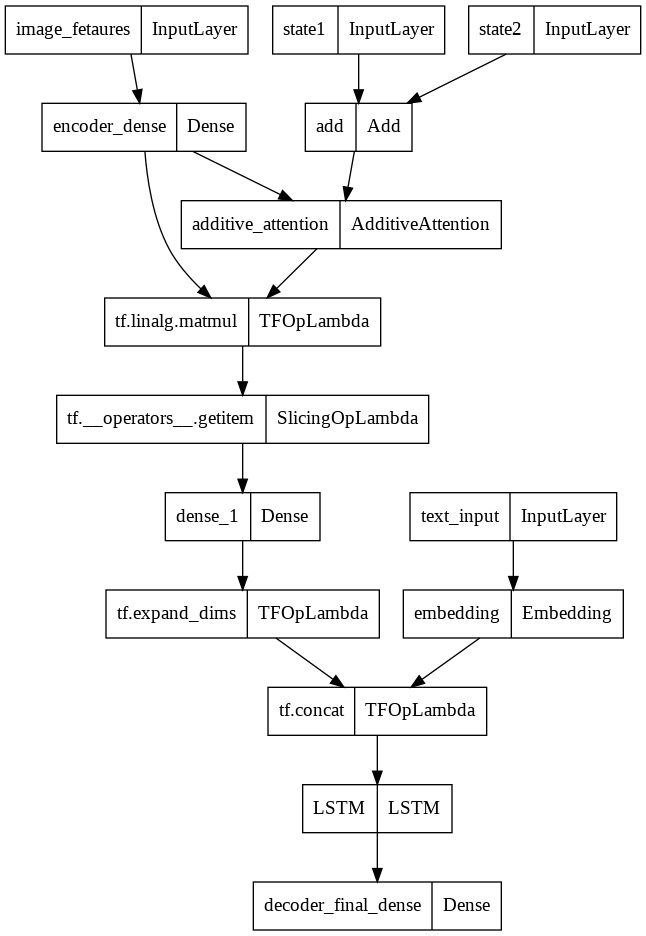

In [18]:
input_img=Input(shape=(98,1024),name="image_features")
input_txt=Input(shape=(maximum_length),name="text_input")

#encoder model
en_out=Dense(enc_units,activation="relu",name="encoder_dense")(input_img)
enc_out=tf.keras.layers.Dropout(0.5)(en_out)

state1= Input(shape=(bsize,enc_units),name="state1")
state2= Input(shape=(bsize,enc_units),name="state2")
state_h=tf.keras.layers.Add()([state_1,state_2])
#decoder model with attention

embed_out=tf.keras.layers.Embedding(vocab_size,output_dim=300,input_length=maximum_length,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_txt)
weights=tf.keras.layers.AdditiveAttention()([state_h,en_out])
context_vector=tf.matmul(en_out,weights,transpose_b=True)[:,:,0]
context_vector=Dense(embedding_dim)(context_vector)
result=tf.concat([tf.expand_dims(context_vector, axis=1),embed_out],axis=1)
lstm_out,state_1,state_2=tf.keras.layers.LSTM(dec_units,return_sequences=True, return_state=True,name="LSTM")(result)
out=tf.keras.layers.Dense(vocab_size,name="decoder_final_dense")(lstm_out)
en_de=Model(inputs=[input_txt,input_img,state1,state2],outputs=out)

keras.utils.plot_model(en_de)

In [19]:
enc_units=64
embedding_dim=300
dec_units=64 
att_units=64
 

In [20]:
#encoder model

#here the input will be image features with size (96,1024). we add another dense layer that will reduce the depth of this feature from 1024 to a low value as encoder output.
class Encoder(tf.keras.Model):
  def __init__(self,units):
    super().__init__()
    self.units=units
    
  
  def build(self,input_shape):
    self.dense1=Dense(self.units,activation="relu",name="encoder_dense")
    self.maxpool=tf.keras.layers.Dropout(0.5)

  def call(self,input_):
    enc_out=self.maxpool(input_)
    enc_out=self.dense1(enc_out) 
    
    return enc_out
    
  def initialize_states(self,batch_size):
      
      #Given a batch size it will return intial hidden state, batch size(64)- Hidden state shape is (64,units)
     
      forward_h=tf.zeros((batch_size,self.units))
      back_h=tf.zeros((batch_size,self.units))
      return forward_h,back_h


In [21]:
#attention model
'''
Here the input to the decoder and the lstm hidden state at the pevious time step are given, and the context vector is calculated.
This context vector is calculated uisng the attention weights. This context vector is then passed to the decoder model.
Here conact function is used for calaculating the attention weights.

'''

class Attention(tf.keras.layers.Layer):

  def __init__(self,att_units):
    super().__init__()    
    self.att_units=att_units

  def build(self,input_shape):
    self.wa=tf.keras.layers.Dense(self.att_units)
    self.wb=tf.keras.layers.Dense(self.att_units)
    self.v=tf.keras.layers.Dense(1)
  
    
  def call(self,decoder_hidden_state,encoder_output):   
    x=tf.expand_dims(decoder_hidden_state,1)      
    alpha_dash=self.v(tf.nn.tanh(self.wa(encoder_output)+self.wb(x)))    
    alphas=tf.nn.softmax(alpha_dash,1)

    context_vector=tf.matmul(encoder_output,alphas,transpose_a=True)[:,:,0]
    return (context_vector,alphas)


In [22]:
#One Step decoder to perform the decoder task.
#The main decoder will call this onestep decoder at every time step. This one step decoder in turn class the atention model and return the ouptput 
#at time step t. This output is passed through the final softmax layer, and pass this result to the main decoder model

class One_Step_Decoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, input_length, dec_units ,att_units):
      
    super().__init__()
    
    self.att_units=att_units
    self.vocab_size=vocab_size
    self.embedding_dim=embedding_dim
    self.input_length=input_length
    
    self.dec_units=dec_units
    self.attention=Attention(self.att_units)
    self.embedding=tf.keras.layers.Embedding(self.vocab_size,output_dim=self.embedding_dim,
                                             input_length=self.input_length,mask_zero=True,trainable=False,weights=[embedding_matrix])   
    self.lstm = tf.keras.layers.LSTM(self.dec_units,return_sequences=True, return_state=True)
    self.dense=tf.keras.layers.Dense(self.vocab_size,name="decoder_final_dense") 
    self.dense_2=tf.keras.layers.Dense(self.embedding_dim,name="decoder_dense2")


  def call(self,input_to_decoder, encoder_output, for_h,bac_h):   

    embed=self.embedding(input_to_decoder)
    state_h=tf.keras.layers.Add()([for_h,bac_h])  
    context_vector,alpha=self.attention(state_h,encoder_output)
    context_vector=self.dense_2(context_vector)
    result=tf.concat([tf.expand_dims(context_vector, axis=1),embed],axis=-1)    
    output,forward_h,back_h=self.lstm(result,initial_state=[for_h,bac_h])  
    out=tf.reshape(output,(-1,output.shape[-1]))
    out=tf.keras.layers.Dropout(0.5)(out)    
    dense_op=self.dense(out)    
    return dense_op,forward_h,back_h,alpha

In [23]:
#Decoder 
#Each output word is generated using one step decoder. Each output word is stored using the final decoder model and the final output sentence is returned

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, output_length, dec_units,att_units):
      super().__init__()
      #Intialize necessary variables and create an object from the class onestepdecoder
      self.onestep=One_Step_Decoder(vocab_size, embedding_dim, output_length, dec_units,att_units)


        
    def call(self, input_to_decoder,encoder_output,state_1,state_2):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        all_outputs=tf.TensorArray(tf.float32,input_to_decoder.shape[1],name="output_array")
        for step in range(input_to_decoder.shape[1]):
          output,state_1,state_2,alpha=self.onestep(input_to_decoder[:,step:step+1],encoder_output,state_1,state_2)

          all_outputs=all_outputs.write(step,output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs
    

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:

class encoder_decoder(tf.keras.Model):
  def __init__(self,enc_units,embedding_dim,vocab_size,output_length,dec_units,att_units,batch_size):
        super().__init__()

        
        self.batch_size=batch_size
        self.encoder =Encoder(enc_units)
        self.decoder=Decoder(vocab_size,embedding_dim,output_length,dec_units,att_units)
        
  
    #Coompute the image features using feature extraction model and pass it to the encoder to get encoder output
    #Pass the decoder sequence,encoder_output,initial states to Decoder and return decoder output


  
  def call(self, data):
        features,report  = data[0], data[1]        
        encoder_output= self.encoder(features)
        state_h,back_h=self.encoder.initialize_states(self.batch_size)        
        output= self.decoder(report, encoder_output,state_h,back_h)
      
        return output

    
      

In [26]:
model  = encoder_decoder(enc_units,embedding_dim,vocab_size,maximum_length,dec_units,att_units,bsize)

In [27]:

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='auto')

def custom_lossfunction(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_ 

In [28]:
model.compile(optimizer=optimizer,loss=custom_lossfunction)


In [29]:
red_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2, min_lr=0.0001) 
ckpt=tf.keras.callbacks.ModelCheckpoint("model2wts/ckpt",monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='auto')

In [39]:
#run this cell 
history = model.fit([train_features[:3050],train_padded_inp[:3050]],train_padded_out[:3050],validation_data=([test_features[:760],test_padded_inp[:760]],test_padded_out[:760]),
       batch_size=bsize,epochs=30,callbacks=[red_lr,ckpt]) 

Epoch 1/30
305/305 [==============================] - ETA: 0s - loss: 0.9542

305/305 [==============================] - 353s 815ms/step - loss: 0.9542 - val_loss: 0.6507 - lr: 0.0010
Epoch 2/30
305/305 [==============================] - ETA: 0s - loss: 0.6071

305/305 [==============================] - 218s 716ms/step - loss: 0.6071 - val_loss: 0.5553 - lr: 0.0010
Epoch 3/30
305/305 [==============================] - ETA: 0s - loss: 0.5325

305/305 [==============================] - 218s 718ms/step - loss: 0.5325 - val_loss: 0.4827 - lr: 0.0010
Epoch 4/30
305/305 [==============================] - ETA: 0s - loss: 0.4780

305/305 [==============================] - 219s 720ms/step - loss: 0.4780 - val_loss: 0.4329 - lr: 0.0010
Epoch 5/30
305/305 [==============================] - ETA: 0s - loss: 0.4414

305/305 [==============================] - 218s 717ms/step - loss: 0.4414 - val_loss: 0.4014 - lr: 0.0010
Epoch 6/30
305/305 [==============================] - ETA: 0s - loss: 0.4150

305/305 [==============================] - 214s 703ms/step - loss: 0.4150 - val_loss: 0.3788 - lr: 0.0010
Epoch 7/30
305/305 [==============================] - ETA: 0s - loss: 0.4000

305/305 [==============================] - 214s 705ms/step - loss: 0.4000 - val_loss: 0.3630 - lr: 0.0010
Epoch 8/30
305/305 [==============================] - ETA: 0s - loss: 0.3854

305/305 [==============================] - 214s 705ms/step - loss: 0.3854 - val_loss: 0.3512 - lr: 0.0010
Epoch 9/30
305/305 [==============================] - ETA: 0s - loss: 0.3730

305/305 [==============================] - 215s 707ms/step - loss: 0.3730 - val_loss: 0.3425 - lr: 0.0010
Epoch 10/30
305/305 [==============================] - ETA: 0s - loss: 0.3647

305/305 [==============================] - 213s 701ms/step - loss: 0.3647 - val_loss: 0.3334 - lr: 0.0010
Epoch 11/30
305/305 [==============================] - ETA: 0s - loss: 0.3568

305/305 [==============================] - 213s 702ms/step - loss: 0.3568 - val_loss: 0.3267 - lr: 0.0010
Epoch 12/30
305/305 [==============================] - ETA: 0s - loss: 0.3494

305/305 [==============================] - 219s 720ms/step - loss: 0.3494 - val_loss: 0.3213 - lr: 0.0010
Epoch 13/30
305/305 [==============================] - ETA: 0s - loss: 0.3435

305/305 [==============================] - 214s 704ms/step - loss: 0.3435 - val_loss: 0.3168 - lr: 0.0010
Epoch 14/30
305/305 [==============================] - ETA: 0s - loss: 0.3393

305/305 [==============================] - 212s 696ms/step - loss: 0.3393 - val_loss: 0.3117 - lr: 0.0010
Epoch 15/30
305/305 [==============================] - ETA: 0s - loss: 0.3342

305/305 [==============================] - 212s 698ms/step - loss: 0.3342 - val_loss: 0.3076 - lr: 0.0010
Epoch 16/30
305/305 [==============================] - ETA: 0s - loss: 0.3293

305/305 [==============================] - 213s 699ms/step - loss: 0.3293 - val_loss: 0.3042 - lr: 0.0010
Epoch 17/30
305/305 [==============================] - ETA: 0s - loss: 0.3253

305/305 [==============================] - 213s 699ms/step - loss: 0.3253 - val_loss: 0.3027 - lr: 0.0010
Epoch 18/30
305/305 [==============================] - ETA: 0s - loss: 0.3204

305/305 [==============================] - 213s 700ms/step - loss: 0.3204 - val_loss: 0.2996 - lr: 0.0010
Epoch 19/30
305/305 [==============================] - ETA: 0s - loss: 0.3165

305/305 [==============================] - 213s 700ms/step - loss: 0.3165 - val_loss: 0.2967 - lr: 0.0010
Epoch 20/30
305/305 [==============================] - ETA: 0s - loss: 0.3138

305/305 [==============================] - 212s 698ms/step - loss: 0.3138 - val_loss: 0.2943 - lr: 0.0010
Epoch 21/30
305/305 [==============================] - ETA: 0s - loss: 0.3106

305/305 [==============================] - 212s 697ms/step - loss: 0.3106 - val_loss: 0.2929 - lr: 0.0010
Epoch 22/30
305/305 [==============================] - ETA: 0s - loss: 0.3087

305/305 [==============================] - 212s 697ms/step - loss: 0.3087 - val_loss: 0.2915 - lr: 0.0010
Epoch 23/30
305/305 [==============================] - ETA: 0s - loss: 0.3066

305/305 [==============================] - 212s 697ms/step - loss: 0.3066 - val_loss: 0.2893 - lr: 0.0010
Epoch 24/30
305/305 [==============================] - ETA: 0s - loss: 0.3029

305/305 [==============================] - 213s 701ms/step - loss: 0.3029 - val_loss: 0.2887 - lr: 0.0010
Epoch 25/30
305/305 [==============================] - ETA: 0s - loss: 0.3008

305/305 [==============================] - 215s 706ms/step - loss: 0.3008 - val_loss: 0.2870 - lr: 0.0010
Epoch 26/30
305/305 [==============================] - ETA: 0s - loss: 0.3008

305/305 [==============================] - 213s 701ms/step - loss: 0.3008 - val_loss: 0.2865 - lr: 0.0010
Epoch 27/30
305/305 [==============================] - ETA: 0s - loss: 0.2969

305/305 [==============================] - 215s 707ms/step - loss: 0.2969 - val_loss: 0.2838 - lr: 0.0010
Epoch 28/30
305/305 [==============================] - 48s 157ms/step - loss: 0.2963 - val_loss: 0.2838 - lr: 0.0010
Epoch 29/30
305/305 [==============================] - ETA: 0s - loss: 0.2950

305/305 [==============================] - 217s 712ms/step - loss: 0.2950 - val_loss: 0.2831 - lr: 0.0010
Epoch 30/30
305/305 [==============================] - ETA: 0s - loss: 0.2912

305/305 [==============================] - 219s 720ms/step - loss: 0.2912 - val_loss: 0.2815 - lr: 0.0010


In [30]:
#model.save_weights("model2wts/bidir_fit_15_b_15")
model.load_weights("model2wts/bidir_fit_15_b_15") 

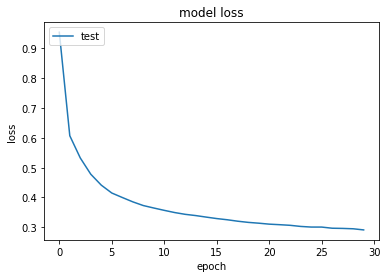

In [52]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

In [31]:
def take_second(elem):
    return elem[1]

Beam Search for evaluation

In [33]:

def beam_search(image1,image2, beam_index):

    hidden_state =  tf.zeros((1, enc_units))
    hidden_state2 =  tf.zeros((1, enc_units))
    image_features=image_feature_extraction(image1,image2)

    encoder_out = model.layers[0](image_features)

    start_token = [token.word_index["<sos>"]]
    dec_word = [[start_token, 0.0]]
    while len(dec_word[0][0]) < maximum_length:
        temp = []
        for word in dec_word:
            
            predict, hidden_state,hidden_state2,alpha = model.layers[1].onestep(tf.expand_dims([word[0][-1]],1), encoder_out, hidden_state,hidden_state2)
           
           
            word_predict = np.argsort(predict[0])[-beam_index:]
            for i in word_predict:

                next_word, probab = word[0][:], word[1]
                next_word.append(i)
                probab += predict[0][i] 
                temp.append([next_word, probab.numpy()])
        dec_word = temp
        # Sorting with respect to the probabilities scores           
        dec_word = sorted(dec_word, key=take_second)      
        # Getting the top words
        dec_word = dec_word[-beam_index:] 
        
     
    final = dec_word[-1]
    
    report =final[0]
    score = final[1]
    temp = []
    
    for word in report:
      if word!=0:
        if word != token.word_index['<eos>']:
            temp.append(token.index_word[word])
        else:
            break 

    rep = ' '.join(e for e in temp)        
    
    return rep, score

NER and Results

In [45]:


## Install scispaCy models
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

# !pip install -U spacy
# !pip install scispacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz (15.6 MB)
  Using cached spacy-3.0.8-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.0 MB)
  Using cached thinc-8.0.17-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (671 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.5
    Uninstalling thinc-8.1.5:
      Successfully uninstalled thinc-8.1.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.3
    Uninstalling spacy-3.4.3:
      Successfully uninstalled spacy-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scispacy 0.5.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.0.8 which is incompatible.
en-core-web-sm 3.4.1 requires 

In [34]:

import scispacy
import spacy

#Core models
import en_core_sci_sm
import en_core_sci_lg

#NER specific models
import en_ner_craft_md
import en_ner_bc5cdr_md
import en_ner_jnlpba_md
import en_ner_bionlp13cg_md

#Tools for extracting & displaying data
from spacy import displacy

In [44]:

def display_NER(result):
  nlp = en_ner_bc5cdr_md.load()
  doc = nlp(result)
  #print(doc)
  #Display resulting entity extraction
  displacy_image = displacy.render(doc, jupyter=True,style='ent')
  print("TEXT", "START", "END", "ENTITY TYPE")
  for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

def pipeline_NER(result):
  nlp_en = en_ner_bc5cdr_md.load()
  nlp_xx = en_ner_bionlp13cg_md.load()
  nlp_en.add_pipe("ner", name="ner_xx", source=nlp_xx)
  doc = nlp_en(result)
  displacy_image = displacy.render(doc, jupyter=True,style='ent')
  print("TEXT", "START", "END", "ENTITY TYPE")
  for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

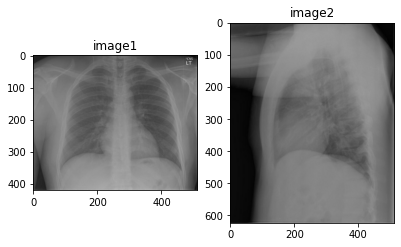

ACTUAL REPORT:  <sos> heart size and mediastinal contours appear within normal limits. pulmonary vascularity within normal limits. focal consolidation suspicious pulmonary opacity pneumothorax definite pleural effusion. visualized osseous structures appear intact.  <eos>
GENERATED REPORT:   lungs are within normal mediastinal contour within the thoracic spine.
BLEU SCORE IS:  0.3803921568627451


TEXT START END ENTITY TYPE
thoracic spine 56 70 TISSUE


In [50]:
import random 
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

chencherry = SmoothingFunction()
start=time.time()
i=random.sample(range(test.shape[0]),1)[0]
img1=test.iloc[i]["image1"]
img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]

result = result.replace("<sos>" , "")
result = result.replace("<eos>" , "")
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ", result)
end=time.time() 
print("BLEU SCORE IS: ",sentence_bleu(result, actual,weights=(1, 0, 0, 0), smoothing_function=chencherry.method5))

#print("time required for the evaluation is ",end-start)     
pipeline_NER(result)
#display_NER(result)

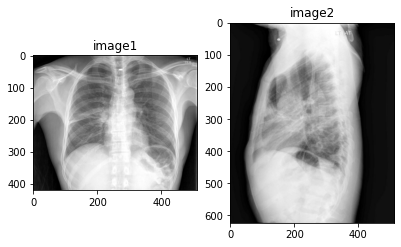

ACTUAL REPORT:  <sos> the heart size normal. the mediastinal contour within normal limits. there streaky opacity within the right upper lobe. there are nodules masses. visible pneumothorax. visible pleural fluid. the are grossly normal. there visible free intraperitoneal air under the diaphragm.  <eos>
GENERATED REPORT:   heart size within normal heart size and soft tissues are unremarkable.
BLEU SCORE IS:  0.3797909407665505
time required for the evaluation is  3.844064474105835


TEXT START END ENTITY TYPE
heart 1 6 ORGAN
heart 26 31 ORGAN
soft tissues 41 53 TISSUE


In [55]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

chencherry = SmoothingFunction()
import random 
start=time.time()
i=random.sample(range(test.shape[0]),1)[0]
img1=test.iloc[i]["image1"]
img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]

result = result.replace("<sos>" , "")
result = result.replace("<eos>" , "")

print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",sentence_bleu(result, actual,weights=(1, 0, 0, 0), smoothing_function=chencherry.method5))

print("time required for the evaluation is ",end-start)     
pipeline_NER(result)
#display_NER(result)

In [45]:
#compute average bleu score for test data
index=range(0,test.shape[0])
bl=0
start1=time.time()
for i in tqdm(index):
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  result,sore=beam_search(img1,img2,3) 
  actual=test_report[i]
  bl+=bleu.sentence_bleu(result, actual,weights=(1, 0, 0, 0), smoothing_function=chencherry.method5)
end1=time.time()
print("\n")
print("average bleu score on the test data is ",bl/test.shape[0])


100%|██████████| 764/764 [1:00:25<00:00,  4.75s/it]



average bleu score on the test data is  0.40975570321007604


In [51]:
#print("the average time for evaluating the attention model with beam search using  LSTM is ", (end1-start1)/764,"seconds")